                                              Sentence  Class  index
0    so there is no way for me to plug it in here i...      0      0
1                          good case, excellent value.      1      1
2                               great for the jawbone.      1      2
3    tied to charger for conversations lasting more...      0      3
4                                    the mic is great.      1      4
..                                                 ...    ...    ...
995  the screen does get smudged easily because it ...      0    995
996  what a piece of junk.. i lose more calls on th...      0    996
997                       item does not match picture.      0    997
998  the only thing that disappoint me is the infra...      0    998
999  you can not answer calls with the unit, never ...      0    999

[1000 rows x 3 columns]

Validation Accuracy: 88.00%

Precision: 0.9184
Recall: 0.8491

Classification Report:
               precision    recall  f1-score   support

    

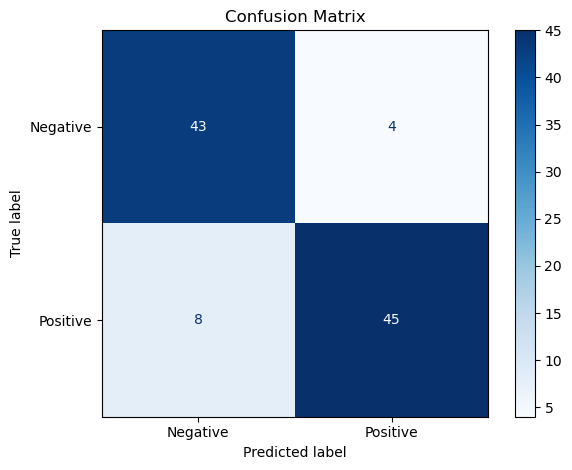

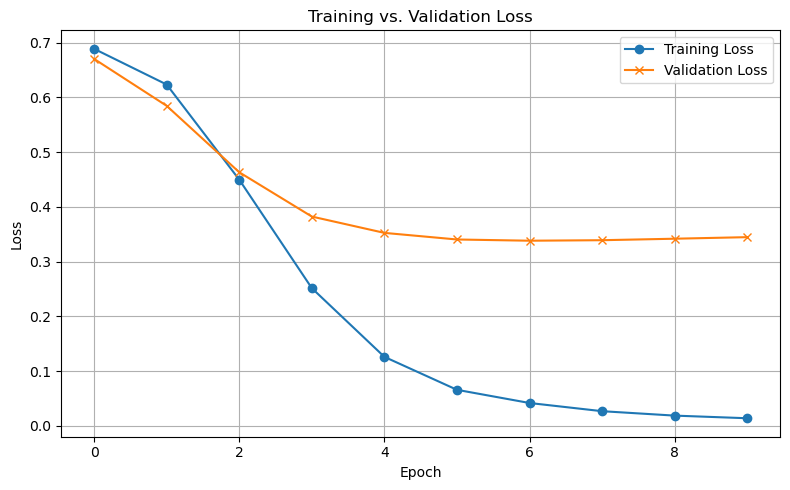

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,ConfusionMatrixDisplay

def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace(r'((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace(r'[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace(r'\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_.loc[len(df_)] = {
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent)
        }
    print(data)
    return data

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

# Set up dataloaders
batch_size = 32
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_losses = []
val_losses = []


# Define ANN Model
class SentimentANN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(SentimentANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 2)  # Binary classification -> 2 output classes

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


# Initialize model
model = SentimentANN(input_dim=train_x_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)


# Final Evaluation (after training is complete)
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    return acc, all_preds, all_labels


# Get final metrics
val_accuracy, all_preds, all_labels = evaluate(model, val_loader)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# Calculate other metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])

# Print metrics
print("\nPrecision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("\nClassification Report:\n", report)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

                                               Sentence  Class  index
0     so there is no way for me to plug it in here i...    0.0      0
1                           good case, excellent value.    1.0      1
2                                great for the jawbone.    1.0      2
3     tied to charger for conversations lasting more...    0.0      3
4                                     the mic is great.    1.0      4
...                                                 ...    ...    ...
5472                             the third one was too.    NaN   5472
5473          this is the very sucks place i ever seen.    NaN   5473
5474  i recommend the hot bagels and deli to my frie...    NaN   5474
5475            great casual (almost divey) atmosphere.    NaN   5475
5476  how fortunate we are that stefano fabbri, owne...    NaN   5476

[5477 rows x 3 columns]

Validation Accuracy: 85.82%

Precision: 0.8496
Recall: 0.8561

Classification Report:
               precision    recall  f1-score   s

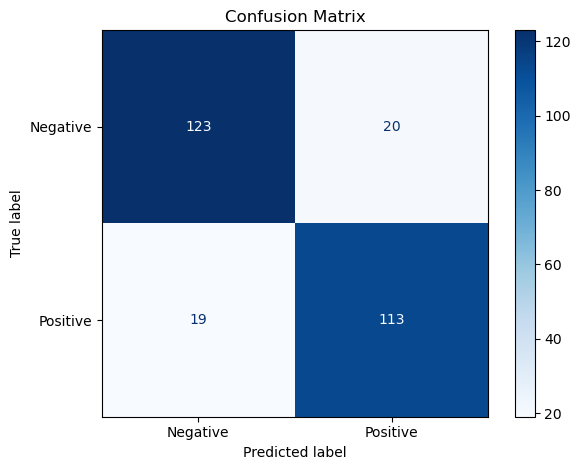

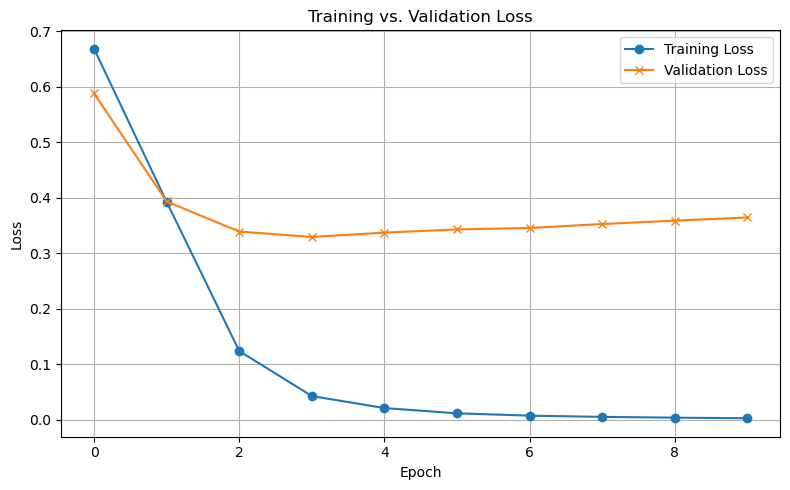

In [15]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_.loc[len(df_)] = {
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent)
        }
    print(data)
    return data

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv(r'''big_data.txt''', delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)                             # pre-process
    data = data.dropna(subset=['Class'])                                # Drop NA values
    training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.10,
        random_state=0,
        shuffle=True
    )

    # vectorize data using TFIDF and transform for PyTorch for scalability
    word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
    training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
    training_data = training_data.todense()                             # convert to dense matrix for Pytorch
    vocab_size = len(word_vectorizer.vocabulary_)
    validation_data = word_vectorizer.transform(validation_data)
    validation_data = validation_data.todense()
    train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
    train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
    validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
    validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()

# Set up dataloaders
batch_size = 32
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
train_losses = []
val_losses = []


# Define ANN Model
class SentimentANN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(SentimentANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, 2)  # Binary classification -> 2 output classes

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


# Initialize model
model = SentimentANN(input_dim=train_x_tensor.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)


# Final Evaluation (after training is complete)
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    return acc, all_preds, all_labels


# Get final metrics
val_accuracy, all_preds, all_labels = evaluate(model, val_loader)
print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")

# Calculate other metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Negative", "Positive"])

# Print metrics
print("\nPrecision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("\nClassification Report:\n", report)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Loading GloVe embeddings...
Epoch 1/10 - Train Loss: 0.5183, Val Loss: 0.4292
Epoch 2/10 - Train Loss: 0.3226, Val Loss: 0.3848
Epoch 3/10 - Train Loss: 0.2161, Val Loss: 0.4374
Epoch 4/10 - Train Loss: 0.1419, Val Loss: 0.4468
Epoch 5/10 - Train Loss: 0.0899, Val Loss: 0.5682
Epoch 6/10 - Train Loss: 0.0638, Val Loss: 0.5995
Epoch 7/10 - Train Loss: 0.0563, Val Loss: 0.5946
Epoch 8/10 - Train Loss: 0.0327, Val Loss: 0.7471
Epoch 9/10 - Train Loss: 0.0259, Val Loss: 0.8536
Epoch 10/10 - Train Loss: 0.0201, Val Loss: 0.9487

Validation Accuracy: 83.64%

Precision: 0.8364
Recall: 0.8364

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84       143
           1       0.83      0.83      0.83       132

    accuracy                           0.84       275
   macro avg       0.84      0.84      0.84       275
weighted avg       0.84      0.84      0.84       275



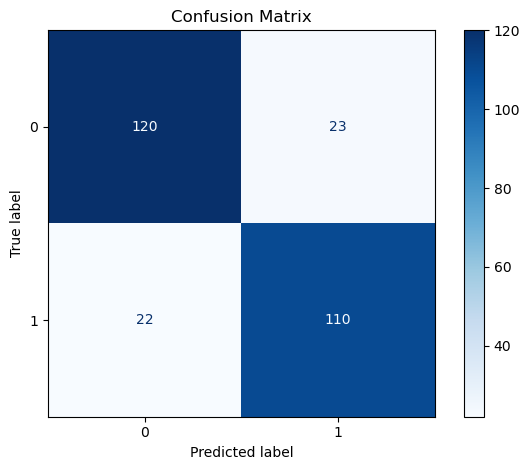

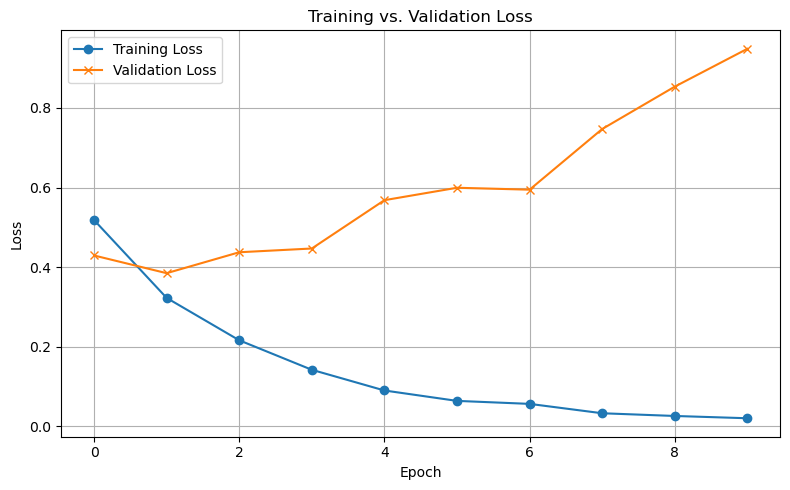

In [13]:
import re
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Preprocess text using NLTK instead of spaCy
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove emails, URLs, etc.
    text = re.sub(r'\S+@\S+', '', text)  # emails
    text = re.sub(r'http\S+', '', text)    # URLs
    text = re.sub(r'www\S+', '', text)     # URLs
    text = re.sub(r'\d+', '', text)        # numbers
    
    # Tokenize and lemmatize
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove stopwords and short tokens
    tokens = [token for token in tokens 
              if token not in stop_words 
              and len(token) > 2 
              and token.isalpha()]
    
    return ' '.join(tokens)

def preprocess_pandas_advanced(data, columns):
    """
    Enhanced preprocessing with NLTK
    """
    df_ = pd.DataFrame(columns=columns)
    
    for index, row in data.iterrows():
        processed_text = preprocess_text(row['Sentence'])
        
        df_.loc[len(df_)] = {
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": processed_text
        }
    
    return df_


def load_embeddings(embedding_type='glove', embedding_dim=300):
    """
    Load pre-trained word embeddings
    """
    if embedding_type == 'glove':
        print("Loading GloVe embeddings...")
        return api.load("glove-wiki-gigaword-300")
    elif embedding_type == 'fasttext':
        print("Loading fastText embeddings...")
        return api.load("fasttext-wiki-news-subwords-300")
    else:
        raise ValueError("Unsupported embedding type")

def create_embedding_matrix(word_index, embedding_dim=300):
    """
    Create embedding matrix for our vocabulary
    """
    embeddings_index = load_embeddings()
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    
    for word, idx in word_index.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
    
    return embedding_matrix

def text_to_sequence(texts, word_index, max_len=100):
    """
    Convert texts to sequences of word indices
    """
    sequences = []
    for text in texts:
        sequence = []
        for word in text.split():
            if word in word_index:
                sequence.append(word_index[word])
        sequences.append(sequence[:max_len])
    return sequences

def pad_sequences(sequences, max_len=100):
    """
    Pad sequences to ensure uniform length
    """
    padded = np.zeros((len(sequences), max_len))
    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = seq[:max_len]
    return padded

class SentimentLSTM(nn.Module):
    def __init__(self, embedding_matrix, num_classes, hidden_dim=128, lstm_layers=1):
        super(SentimentLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        
        # Embedding layer with pre-trained weights
        self.embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(embedding_matrix),
            freeze=False  # Fine-tune embeddings during training
        )
        
        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )
        
        # Classifier
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # Embed the input
        embedded = self.embedding(x)
        
        # LSTM layer
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Concatenate the final hidden states from both directions
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        
        # Classifier
        out = self.dropout(hidden)
        out = self.fc(out)
        
        return out

if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv(r'''big_data.txt''', delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index
    
    # Enhanced preprocessing
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas_advanced(data, columns)
    data = data.dropna(subset=['Class'])
    
    # For multi-class classification, ensure labels start from 0
    num_classes = len(data['Class'].unique())
    data['Class'] = data['Class'].astype('int64')  # For multi-class
    
    # Split data
    training_data, validation_data, training_labels, validation_labels = train_test_split(
        data['Sentence'].values.astype('U'),
        data['Class'].values,
        test_size=0.10,
        random_state=0,
        shuffle=True
    )
    
    # Create vocabulary
    word_counts = Counter()
    for text in training_data:
        word_counts.update(text.split())
    
    # Create word index mapping
    word_index = {word: idx+1 for idx, word in enumerate(word_counts.keys())}
    
    # Create embedding matrix
    embedding_matrix = create_embedding_matrix(word_index)
    
    # Convert texts to sequences
    train_sequences = text_to_sequence(training_data, word_index)
    val_sequences = text_to_sequence(validation_data, word_index)
    
    # Pad sequences
    max_len = 100  # Adjust based on your data
    train_x = pad_sequences(train_sequences, max_len)
    val_x = pad_sequences(val_sequences, max_len)
    
    # Convert to tensors
    train_x_tensor = torch.from_numpy(train_x).long()
    train_y_tensor = torch.from_numpy(training_labels).long()
    val_x_tensor = torch.from_numpy(val_x).long()
    val_y_tensor = torch.from_numpy(validation_labels).long()
    
    # Data loaders
    batch_size = 32
    train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    model = SentimentLSTM(
        embedding_matrix=embedding_matrix,
        num_classes=num_classes,
        hidden_dim=128,
        lstm_layers=1
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    epochs = 10
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Evaluation
    def evaluate(model, dataloader):
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        return acc, all_preds, all_labels
    
    val_accuracy, all_preds, all_labels = evaluate(model, val_loader)
    print(f"\nValidation Accuracy: {val_accuracy * 100:.2f}%")
    
    # Calculate metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds)
    
    # Print metrics
    print("\nPrecision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("\nClassification Report:\n", report)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # Plot training vs validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title("Training vs. Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()